In [ ]:
# !pip install monai
# !pip install torchmetrics
# !pip install segmentation_models_pytorch

In [1]:
import os
import pickle
import segmentation_models_pytorch as smp
from monai.data import DataLoader, Dataset
from monai.utils import set_determinism
import torch
from torchmetrics import JaccardIndex
from tqdm import tqdm
from transformers import SegformerConfig, SegformerForSemanticSegmentation
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')


In [2]:
# # mount google drive
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# root_dir = "/content/drive/MyDrive/"
# root_dir = os.path.join(root_dir, "ISLES-2022")
# os.path.exists(root_dir)

False

In [93]:
from torchvision import models
import torch
import torch.nn as nn
import torch.nn.functional as F

class conv_block(nn.Module):
    def __init__(self, ch_in, ch_out) -> None:
        """
        conv_block: Convolutional block with two convolutional layers with batch normalization and ReLU activation.
        no change in size of the image.
        """
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,  padding=1),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch_out, ch_out, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True))

    def forward(self, x):
        return self.conv(x)


class Upsample(nn.Module):
    def __init__(self,ch_in,ch_out):
        """
        Upsample: Upsample the image by a factor of 2 and then apply a convolutional layer.
        No change in the size of the image.
        """
        super().__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(ch_in,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
		    nn.BatchNorm2d(ch_out),
			nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.up(x)
        return x

class UNET(nn.Module):
    def __init__(self,img_ch=3,output_ch=1):
        super().__init__()

        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2) # reduce the size of the image by half

        self.enc1 = conv_block(ch_in=img_ch,ch_out=64)
        self.enc2 = conv_block(ch_in=64,ch_out=128)
        self.enc3 = conv_block(ch_in=128,ch_out=256)
        self.enc4 = conv_block(ch_in=256,ch_out=512)

        self.bottle_neck = conv_block(ch_in=512, ch_out=1024)

        self.Upconv4 = nn.ConvTranspose2d(1024,512,kernel_size=2,stride=2) # increase the size of the image by 2 and decrease the number of channels by half
        self.dec4 = conv_block(ch_in=1024, ch_out=512)

        self.UpConv3 = nn.ConvTranspose2d(512,256,kernel_size=2,stride=2)
        self.dec3 = conv_block(ch_in=512,ch_out=256)

        self.UpConv2 = nn.ConvTranspose2d(256,128,kernel_size=2,stride=2)
        self.dec2 = conv_block(ch_in=256,ch_out=128)

        self.UpConv1 = nn.ConvTranspose2d(128,64,kernel_size=2,stride=2)
        self.dec1 = conv_block(ch_in=128,ch_out=64)

        self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)


    def forward(self, x):
        # x: B, img_ch, H, W


        # encoding path
        e1 = self.enc1(x)  # B, 64, H, W

        e2 = self.enc2(self.Maxpool(e1))  # B, 128, H/2, W/2
        e3 = self.enc3(self.Maxpool(e2))  # B, 256, H/4, W/4
        e4 = self.enc4(self.Maxpool(e3)) # B, 512, H/8, W/8

        bottle_neck = self.bottle_neck(self.Maxpool(e4)) # B, 1024, H/16, W/16

        d4 = self.Upconv4(bottle_neck) # B, 512, H/8, W/8
        d4 = torch.cat((d4, e4), dim=1) # B, 1024, H/8, W/8
        d4 = self.dec4(d4) # B, 512, H/8, W/8

        d3 = self.UpConv3(d4) # B, 256, H/4, W/4
        d3 = torch.cat((d3,e3),dim=1) # B, 512, H/4, W/4
        d3 = self.dec3(d3) # B, 256, H/4, W/4

        d2 = self.UpConv2(d3) # B, 128, H/2, W/2
        d2 = torch.cat((d2,e2),dim=1) # B, 256, H/2, W/2
        d2 = self.dec2(d2) # B, 128, H/2, W/2

        d1 = self.UpConv1(d2) # B, 64, H, W
        d1 = torch.cat((d1,e1),dim=1) # B, 128, H, W
        d1 = self.dec1(d1) # B, 64, H, W

        out = self.Conv_1x1(d1) # B, output_cha, H, W
        out = F.sigmoid(out)
        return out
        # Decoder path
class ResNetUNet(nn.Module):
    def __init__(self, output_ch=1):
        super().__init__()

        # Use a pretrained ResNet34 model but remove the fully connected layer and the final pooling layer
        self.resnet = models.resnet34(pretrained=True)
        self.resnet_layers = list(self.resnet.children())[:-2]
        self.resnet_encoder = nn.Sequential(*self.resnet_layers)
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2) # reduce the size of the image by half

        # Encoder channels based on ResNet34 architecture
        enc_chs = [64, 64, 128, 256, 512]

        self.bottle_neck = conv_block(ch_in=256, ch_out=512)

        # Decoder components

        self.UpConv4 = nn.ConvTranspose2d(512,256,kernel_size=2,stride=2)
        self.dec4 = conv_block(ch_in=512,ch_out=256)

        self.UpConv3 = nn.ConvTranspose2d(256,128,kernel_size=2,stride=2)
        self.dec3 = conv_block(ch_in=256,ch_out=128)

        self.UpConv2 = nn.ConvTranspose2d(128,64,kernel_size=2,stride=2)
        self.dec2 = conv_block(ch_in=128,ch_out=64)

        self.UpConv1 = nn.ConvTranspose2d(64,64,kernel_size=2,stride=2)
        self.dec1 = conv_block(ch_in=128,ch_out=64)

        self.UpConv0 = nn.ConvTranspose2d(128,64,kernel_size=2,stride=2)

        self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)

    def forward(self, x):
        # x: B, img_ch, H, W
        e1 = self.resnet_encoder[0:3](x) # B, 64, H/2, W/2
        e2 = self.resnet_encoder[3:5](e1) # B, 64, H/4, W/4
        e3 = self.resnet_encoder[5](e2) # B, 128, H/8, H/8
        e4 = self.resnet_encoder[6](e3) # B, 256, H/16, H/16
        # print(e4.shape)

        # print(1)

        bottle_neck = self.bottle_neck(self.Maxpool(e4)) # B, 512, H/32, H/32
        # print(bottle_neck.shape)


        d4 = self.UpConv4(bottle_neck) # B, 256, H/16, H/16
        d4 = torch.cat((d4,e4),dim=1) # B, 512, H/16, H/16
        d4 = self.dec4(d4) # B, 256, H/16, H/16
        # print(d4.shape)

        d3 = self.UpConv3(d4) # B, 128, H/8, H/8
        d3 = torch.cat((d3,e3),dim=1) # B, 256, H/8, H/8
        d3 = self.dec3(d3) # B, 128, H/8, H/8
        # print(d3.shape)

        d2 = self.UpConv2(d3) # B, 64, H/4, H/4
        d2 = torch.cat((d2,e2),dim=1) # B, 128, H/4, H/4
        d2 = self.dec2(d2) # B, 64, H/4, H/4
        # print("d2", d2.shape)

        d1 = self.UpConv1(d2) # B, 64, H/2, H/2
        # print("d1", d1.shape)
        # print("e1", e1.shape)
        d1 = torch.cat((d1,e1),dim=1) # B, 64, H, H

        d0 = self.UpConv0(d1) # B, 64, H, H
        # print("d0", d0.shape)
        # print(d0.shape)


        out = self.Conv_1x1(d0) # B, output_cha, H, W
        out = F.sigmoid(out)


        return out
        # Decoder path



In [94]:
# import custom model
from custom_model import CustomModel

### Load preprocessed data

In [95]:
root_dir = "."

In [96]:
# make sure those files exist before running this cell
# with open(os.path.join(root_dir, 'full_kfold_splits.pkl'), 'rb') as f:
#     folds = pickle.load(f)
# with open(os.path.join(root_dir, 'full_test_set.pkl'), 'rb') as f:
#     test_set = pickle.load(f)


In [97]:
with open(os.path.join(root_dir, 'three_sequence_train_set.pkl'), 'rb') as f:
    train_set = pickle.load(f)
with open(os.path.join(root_dir, 'three_sequence_test_set.pkl'), 'rb') as f:
    test_set = pickle.load(f)

In [98]:
# gpu = "cuda"
# loss = "Jaccard"
# model_type = "resnet"

In [99]:

# x = torch.randn(1, 3, 128, 128)
# model = CustomModel(
#         channels = [64, 128, 256, 512],
#         scale = [4, 2, 2, 2],
#         num_blocks = [2, 2, 2, 2],
#         num_heads = [2, 4, 8, 16],
#         mlp_hidden = [256, 512, 1024, 2048],
#         dropout = 0.0,                     # change to dropout rate=0.2
#         decoder_hidden = 256,
#         attention=True, # whether to use attention gate
#     )
# l =model.encoder(x)
# for i in range(len(l)):
#     print(l[i].shape)
# l.reverse()
# model.decoder(l).shape


In [100]:
# if gpu == "cuda":
#     device = torch.device("cuda:0")

# if loss == "Dice":
#     loss_function = smp.losses.DiceLoss(mode="binary", from_logits=False)
# elif loss == "Jaccard":
#     loss_function = smp.losses.JaccardLoss(mode="binary", from_logits=False)

# metric = JaccardIndex(task="binary").to(device)

### Define training function

In [102]:
def get_model(model_type, device, attention_gate_flag=False):
    if model_type == "resnet":
     
        # model = smp.Unet(
        #     encoder_name="resnet34",
        #     in_channels=3,
        #     classes=1,
        #     activation="sigmoid",
        #     encoder_weights=None,
        # ).to(device)
        model = ResNetUNet(output_ch=1).to(device)
    elif model_type == "unet":
        # model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
        # in_channels=3, out_channels=1, init_features=32, pretrained=False).to(device)
        model = UNET(img_ch=3, output_ch=1).to(device)
    elif model_type == "segformer":
        config = SegformerConfig(num_labels=1)
        model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512", num_labels=1, ignore_mismatched_sizes=True).to(device)
    elif model_type == "custom":
        model = CustomModel(
            channels = [64, 128, 256, 512],
            scale = [4, 2, 2, 2],
            num_blocks = [2, 2, 2, 2],
            num_heads = [2, 4, 8, 16],
            mlp_hidden = [256, 512, 1024, 2048],
            dropout = 0.2,                     # change to dropout rate=0.2
            decoder_hidden = 256,
            attention=attention_gate_flag, # whether to use attention gate
        ).to(device)

    return model


In [103]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    # trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total number of parameters: {total_params}")
    # print(f"Number of trainable parameters: {trainable_params}")
    return total_params
# count_parameters(model)

In [104]:
def add_model_par(df_model_par, model_type, parameters_num):
    """
    df_model_par: dataframe to save model parameters
    model_type: resnet, unet, segformer, custom
    parameters_num: number of parameters
    """
    next_index = len(df_model_par)
    df_model_par.loc[next_index] = [model_type, parameters_num]

In [105]:
def train_model(model_type, df_model_par, out_dir, loss_function, metric, device, lr=1e-4, attention_gate_flag=False):
    """
    model_type: resnet, unet, segformer, custom
    df_model_par: dataframe to save model parameters size
    out_dir: root directory of the dataset
    loss_function: loss function to evaluate the model, Dice or Jaccard
    metric: metric to evaluate the model, JaccardIndex(IoU) or  Dice
    device: device to train the model
    lr: learning rate
    attention_gate_flag: whether to use attention gate in custom model
    """


    model = get_model(model_type, device, attention_gate_flag=attention_gate_flag)
    add_model_par(df_model_par, model_type, count_parameters(model))
    train_ds = train_set["train"]
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4)
    val_ds = train_set["val"]
    val_loader = DataLoader(val_ds, batch_size=8, num_workers=4)


    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

    # use amp to accelerate training
    scaler = torch.cuda.amp.GradScaler()
    # enable cuDNN benchmark
    torch.backends.cudnn.benchmark = True

    val_interval = 2
    best_metric = -1
    best_metric_epoch = -1
    epoch_loss_values = []
    metric_values = []

    num_CV = 5
    max_epochs = 200

  
    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")
        

        # Training
        model.train()
        epoch_loss = 0
        step = 0

        for batch_data in tqdm(train_loader, desc="Training"):
            step += 1
            inputs, labels = (
                batch_data["image"].to(device),
                batch_data["label"].to(device),
            )

            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                inputs.to(torch.float32)
                outputs = model(inputs)
                if model_type == "segformer":
                    outputs = torch.nn.functional.sigmoid(torch.nn.functional.interpolate(outputs.logits,128,mode="bilinear",align_corners=False))
                loss = loss_function(outputs, labels)

            if torch.isnan(loss) or torch.isnan(torch.flatten(outputs)).any().item():
                print(outputs)
                print(torch.isnan(torch.flatten(outputs)).any())
                print(labels)
                print(loss)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            epoch_loss += loss.item()

        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        # Validation
        if (epoch + 1) % val_interval == 0:
            model.eval()
            val_iou = 0.0
            num_batches = len(val_loader)

            with torch.no_grad():
                for val_data in tqdm(val_loader, desc="Validation"):
                    val_inputs, val_labels = (
                        val_data["image"].to(device),
                        val_data["label"].to(device),
                    )

                    val_outputs = model(val_inputs)
                    if model_type == "segformer":
                        val_outputs = torch.nn.functional.sigmoid(torch.nn.functional.interpolate(val_outputs.logits,128,mode="bilinear",align_corners=False))

                    # Calculate IoU
                    iou = metric(val_outputs, val_labels)
                    val_iou += iou.item()

            # Calculate average IoU across all batches
            average_val_iou = val_iou / num_batches
            metric_values.append(average_val_iou)

            if average_val_iou > best_metric:
                best_metric = average_val_iou
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(out_dir, "best_metric_model.pth"))
                print("saved new best metric model")

            print(
                f"current epoch: {epoch + 1} current mean IoU: {average_val_iou:.4f}"
                f"\nbest mean IoU: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )
    return epoch_loss_values, metric_values


In [106]:
def plot_train_curve(epoch_loss_values, metric_values, model_type, out_dir):

    epoch_loss_array = np.array(epoch_loss_values)
    metric_array = np.array(metric_values)
    np.savetxt(os.path.join(out_dir, 'epoch_loss_array.csv'), epoch_loss_array, delimiter=',')
    np.savetxt(os.path.join(out_dir, 'metric_array.csv'), metric_array, delimiter=',')


    plt.figure("train", (12, 6))
    plt.subplot(1, 2, 1)
    plt.title(f"{model_type} Epoch Average Loss")
    x = [i + 1 for i in range(len(epoch_loss_values))]
    y = epoch_loss_values
    plt.xlabel("epoch")
    plt.plot(x, y)
    plt.subplot(1, 2, 2)
    plt.title(f"{model_type} Val Mean IoU ")
    x = [2 * (i + 1) for i in range(len(metric_values))]
    y = metric_values
    plt.xlabel("epoch")
    plt.plot(x, y)
    plt.savefig(os.path.join(out_dir, "train_curve.png"))
    plt.show()

# plot_train_curve(epoch_loss_values, metric_values, out_dir)




### Training

In [107]:
gpu = "cuda"
loss = "Jaccard"

In [108]:
if gpu == "cuda":
    device = torch.device("cuda:0")

if loss == "Dice":
    loss_function = smp.losses.DiceLoss(mode="binary", from_logits=False)
elif loss == "Jaccard":
    loss_function = smp.losses.JaccardLoss(mode="binary", from_logits=False)

metric = JaccardIndex(task="binary").to(device)

In [109]:
loss_function, metric

(JaccardLoss(), BinaryJaccardIndex())

In [110]:
# dataframe to save model parameters
df_model_par = pd.DataFrame(columns=['model_type', 'parameters_num'])
print(root_dir)
print(device)

.
cuda:0


In [114]:
# model_list = ["custom", "unet", "resnet", "segformer"]
model_list = ["unet"]

In [115]:
set_determinism(0) # set random seed


In [116]:
for model_type in model_list:
    os.makedirs(os.path.join(root_dir, model_type), exist_ok=True)
    out_dir = os.path.join(root_dir, model_type)
    loss_values, metric_values = train_model(model_type, df_model_par, out_dir, loss_function, metric, device, lr=1e-4, attention_gate_flag=True)
    plot_train_curve(loss_values, metric_values, model_type, out_dir)

Total number of parameters: 31043521
----------
epoch 1/200


Training: 100%|██████████| 121/121 [00:50<00:00,  2.41it/s]


epoch 1 average loss: 0.9638
----------
epoch 2/200


Training:   0%|          | 0/121 [00:05<?, ?it/s]


KeyboardInterrupt: 

Testing

In [42]:
test_loader = DataLoader(
    test_set, batch_size=8, num_workers=4
)
out_dir

'.\\unet'

In [43]:
root_dir

'.'

In [44]:
# model_list = ["resnet", "unet", "segformer", "custom"]
model_list = ["custom", "unet"]

In [45]:
def get_dice(pred, target):
    smooth = 1e-15
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

Using cache found in C:\Users\frank/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master


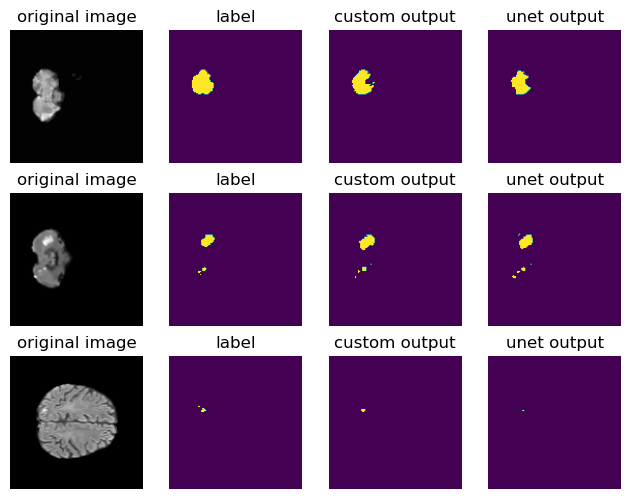

In [46]:
mean_test_metric = pd.DataFrame(columns=['model_tye', 'mean_test_iou', 'mean_test_dice'])
plt.figure("check", (12, 6))
for j in range(len(model_list)):
    model_type = model_list[j]
    model = get_model(model_type, device, attention_gate_flag=True)
    model.load_state_dict(torch.load(os.path.join(root_dir, model_type, "best_metric_model.pth")))
    model.eval()
    test_metric_values = []
    test_dice_values = []
    with torch.no_grad():
        for i, test_data in enumerate(test_loader):

            test_outputs = model(test_data["image"].to(device))
            test_labels = test_data["label"].to(device)
            if model_type == "segformer":
                test_outputs = torch.nn.functional.sigmoid(torch.nn.functional.interpolate(test_outputs.logits,128,mode="bilinear",align_corners=False))

            test_outputs = test_outputs.float() > 0.5
            iou = metric(test_outputs, test_labels)
            dice_val = get_dice(test_outputs, test_labels)
            test_metric_values.append(iou.item())
            test_dice_values.append(dice_val.item())


            # for j in range(10):
            if i >= 30 and i < 33:
                k = i - 30
                if j == 0:
                    plt.subplot(3, 6, 1 + 6 * k)
                    plt.title("original image")
                    plt.axis("off")
                    plt.imshow(test_data["image"][0, 0, :, :], cmap="gray")
                    plt.subplot(3, 6, 2 + 6 * k)
                    plt.title("label")
                    plt.axis("off")
                    plt.imshow(test_data["label"][0, 0, :, :])
                plt.subplot(3, 6, j + 3 + 6 * k)
                plt.title(f"{model_type} output")
                plt.axis("off")

                plt.imshow(test_outputs.detach().cpu()[0, 0, :, :])
    mean_test_metric.loc[j] = [model_type, sum(test_metric_values) / len(test_metric_values), sum(test_dice_values) / len(test_dice_values)]
plt.savefig(os.path.join(root_dir, f"model_comparison.png"))
plt.show()


In [47]:
mean_test_metric

,model_tye,mean_test_iou,mean_test_dice
0,custom,0.765703,0.862813
1,unet,0.781753,0.874216


In [93]:
df_model_par['parameters_num_millions'] = df_model_par['parameters_num'] / 1_000_000

In [99]:
df_model_par

,model_type,parameters_num,parameters_num_millions
0,resnet,24436369,24.436369
1,unet,7763041,7.763041
2,segformer,3714401,3.714401
3,custom,51145311,51.145311


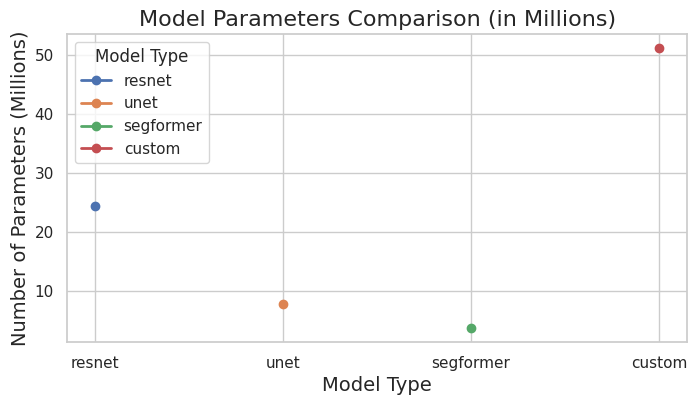

In [102]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 4))
for idx, row in df_model_par.iterrows():
    plt.plot([row['model_type']], [row['parameters_num_millions']], label=row['model_type'], marker='o', linestyle='-', linewidth=2)
plt.title('Model Parameters Comparison (in Millions)', fontsize=16)
plt.xlabel('Model Type', fontsize=14)
plt.ylabel('Number of Parameters (Millions)', fontsize=14)
plt.legend(title='Model Type')
plt.savefig(os.path.join(root_dir, "model_parameters_line_plot.png"), dpi=300)
plt.show()